# Merian Part 1: catalogs and scaling relations

**Prerequisites**
- Finished the Photometric Redshift notebook

In [4]:
%load_ext autoreload
%autoreload 2
import os, sys
from IPython.display import clear_output

import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.coordinates import SkyCoord

# We can beautify our plots by changing the matpltlib setting a little
plt.rcParams['font.size'] = 18
plt.rcParams['image.origin'] = 'lower'
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['figure.dpi'] = 90
plt.rcParams['axes.linewidth'] = 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
required_packages = []  # Define the required packages for this notebook

import sys
import subprocess

try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

if IN_COLAB:
    # Download utils.py
    !wget -q -O /content/utils.py https://raw.githubusercontent.com/AstroJacobLi/ObsAstGreene/refs/heads/main/book/docs/utils.py
    # Function to check and install missing packages
    def install_packages(packages):
        for package in packages:
            try:
                __import__(package)
            except ImportError:
                print(f"Installing {package}...")
                subprocess.check_call([sys.executable, '-m', 'pip', 'install', package])
    # Install any missing packages
    install_packages(required_packages)
else:
    # If not in Colab, adjust the path for local development
    sys.path.append('/Users/jiaxuanl/Dropbox/Courses/ObsAstGreene/book/docs/')

# Get the directory right
if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive/')
  os.chdir('/content/drive/Shareddrives/AST207/data')
else:
    os.chdir('../../_static/ObsAstroData/')

## 1: Understand the Merian survey

The Merian survey uses two medium-band filters (N540 and N708) on the 4-m Blanco telescope to obtain deep imaging data for dwarf galaxies. From the Photometric Redshift notebook, we already know that galaxies at different redshifts will have different magnitudes in certain bands as the emission lines pass through these filters. In this notebook, we start to work on the real Merian data and try to have a deeper understanding of photo-$z$s. To start with, we will look at how the $i - \rm N708$ color depends on the galaxy's redshift. 

In the cell below, we load the master catalog and only select those galaxies with solid spectroscopic redshifts (`cat['z_desi']` is the spectroscopic redshift), such that we have a truth for redshift to compare with photo-zs. We also narrow the redshift range to $0 < z < 0.6$. 

We will also convert the measured "flux" to magnitudes:

$$ m = -2.5 \log10 (f) + \mathrm{ZP},$$

where $f$ is the flux (in any unit), and $\rm ZP$ is the zeropoint. For Merian, we use $\rm ZP = 31.4$ for these catalogs.

In [7]:
cat = Table.read('./merian/cosmos_Merian_DR1_photoz_v1.0.fits')
cat = cat[cat['z_desi'] != -99.0]
cat = cat[cat['good_desi']] # ensure good DESI spec-z
cat = cat[cat['z_desi'] < 0.6]

zp = 31.4 # this is the photometric zeropoint for Merian
for filt in ['g', 'r', 'i', 'N708', 'N540']:
    cat[f'mag_{filt}'] = zp - 2.5 * np.log10(cat[f'{filt}_gaap1p0Flux_Merian'])
z_spec = cat['z_desi']

Now we have a sample of galaxies with solid spectroscopic redshifts (spec-z) in the COSMOS field. Let's plot the $i - \rm N708$ color as a function of spec-z in the following plot. As a reminder, you can get the $i-\rm N708$ using `cat['mag_i'] - cat['mag_N708']`. 

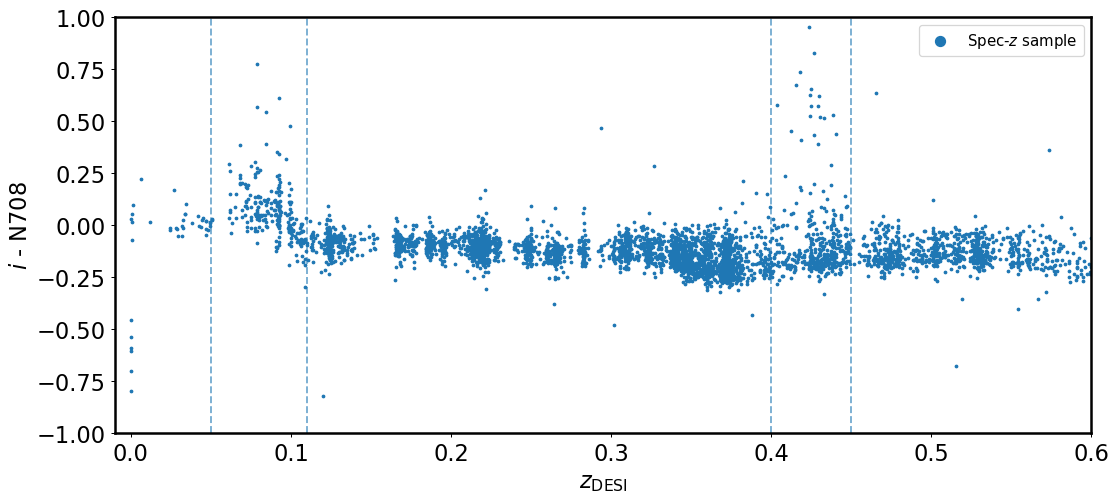

In [32]:
fig, axes = plt.subplots(1, 1, figsize=(14, 6), sharey=True)

plt.sca(axes)
sct = plt.scatter(cat['z_desi'], cat['mag_i'] - cat['mag_N708'], s=4, label='Spec-$z$ sample')

plt.axvline(0.05, ls='--', alpha=0.6)
plt.axvline(0.11, ls='--', alpha=0.6)

plt.axvline(0.4, ls='--', alpha=0.6)
plt.axvline(0.45, ls='--', alpha=0.6)

plt.ylim(-1, 1.0)
plt.xlim(-0.01, 0.6)
plt.xlabel('$z_\mathrm{DESI}$')
plt.ylabel('$i$ - N708')
leg = plt.legend(loc='upper right', fontsize=12, scatterpoints=1, frameon=True, markerscale=4)
plt.subplots_adjust(wspace=0.05)

**Exercise 1**

1. From the above figure, we see two spikes at $0.05 < z < 0.11$ and $0.4 < z < 0.45$. What is causing these two spikes? (You may use the interactive tools in the Photometric Redshift notebook)

2. Why galaxies have $i - \rm N708 \approx 0$ at $z=0.2-0.3$?

3. What can we say about the redshift if we only have the N708 filter? Will there be any degeneracy? 

In [ ]:
## your answer

**Exercise 2**
1. Plot the figure above, but color-code the data points using the $r- \rm N540$ color. Use the colormap `bwr`, and set the colorbar min value to -0.3, and max value to 0.3. 
2. Now revisit the two spikes at $0.05 < z < 0.11$ and $0.4 < z < 0.45$. Do they have the same $r-\rm N540$ color? Do you now have a way to distinguish the second spike from the first spike? 

In [ ]:
## your answer

From the exercises above, we now have a good understanding of why we need two filters (aka N540 and N708) to ping down the photometric redshift of galaxies. Using more advanced tools, we were able to derive the photometric redshifts for Merian galaxies using the $grizy$ broad-bands plus the two medium bands (N540 and N708). The derived photo-z is `cat['zphot_1p0']`. 

**Exercise 3**
1. Make a scatter plot for the spec-z v.s. photo-z. Also, plot a one-to-one line for reference, and set `xlim` and `ylim` to `(0, 0.6)`. Make sure to add axis labels.
2. Is photo-z a perfect indicator of a galaxy's redshift? Can we 100% trust it?
3. To quantify the scatter of the photo-z w.r.t. spec-z, people define a quantity $\Delta z / (1+z_{\rm spec})$, where $\Delta z = z_{\rm phot} - z_{\rm spec}$. Please calculate the median and 1-sigma standard deviation of this quantity for galaxies at $z<0.1$. The standard deviation, $\sigma_{\Delta z / (1+z)}$, is often used to quantify the photo-z accuracy.

In [ ]:
## your answer

## 2. Scaling relations

In this section, we will only select those galaxies in our redshift range ($0.05 < z < 0.11$, i.e., the first spike). Then, let's explore the correlation among the physical properties. 

In [47]:
cat_inband = cat[(z_spec < 0.11) & (z_spec > 0.05) & (cat['mag_i'] < 21.5)] # we require i_mag < 21.5 to make sure all galaxies have high S/N

In [184]:
len(cat_inband)

161

**Exercise 4**

1. Plot the histogram of the log10(stellar mass) (`mass_1p0`), redshift (`z_desi`), `i-N708` color, and the log10(star-formation rate) (`sfr_1p0`).
2. Make a scatter plot for log star formation rate v.s. log stellar mass. Do you see any correlation? Describe it.
3. Plot any other combinations of properties that you think might be interesting. Comment on what you see. You can also color-code the scatter plot by a third quantity. 

In [ ]:
## your answer